In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
root = "/content/drive/MyDrive/final/"
# IF not running in colab, commet above and uncomment below
# root = "./"

!pip install transformers sentencepiece

from transformers             import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig,Trainer, TrainingArguments, BertweetTokenizer, BertConfig, RobertaModel,RobertaTokenizer, XLMRobertaTokenizer, XLMRobertaModel
from torch.utils.data         import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics          import f1_score, roc_auc_score, balanced_accuracy_score, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection  import train_test_split
from collections              import Counter
from tqdm                     import tqdm
from torch.nn.utils.rnn       import pad_sequence

import torch.nn.functional as F
import numpy  as np
import pandas as pd

import copy
import torch
import os
import random
import re
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.1 MB/s eta 0:00:00


device(type='cuda')

In [ ]:
# only to train
DATASET_PATH = "dataset/"

DATA1_KAGGLE_PATH     = 'clickbait_data.csv'
DATA2_ClickBait_PATH  = 'clickbait.txt'
DATA2_Genuine_PATH    = 'genuine.txt'
WEBIS_TRAIN_PATH      = 'webis_train.csv'
WEBIS_TEST_PATH       = 'webis_test.csv'

ColumnData  = 'headline'
ColumnLabel = 'clickbait'

def readTxt(filePath):
  filePath =  filePath
  with open(filePath, "r") as f:
    sentence = []
    line = f.readline()
    while line:
      sentence.append(line.rstrip('\n'))      
      line = f.readline()
    
    return sentence

# Prepare DATA 1: kaggle clicbait challenge
df_DataA = pd.read_csv(root + DATASET_PATH + DATA1_KAGGLE_PATH)

# Prepare DATA 2: Mathur's dataset 
clickBait     = readTxt(root + DATASET_PATH +DATA2_ClickBait_PATH)
nonClickBait  = readTxt(root + DATASET_PATH +DATA2_Genuine_PATH)

labelA = [1] * len(clickBait)
labelB = [0] * len(nonClickBait)

datasetB_X = clickBait + nonClickBait
datasetB_Y = labelA + labelB

dataB_text = np.array(datasetB_X, dtype = object)
dataB_labels = np.array(datasetB_Y)
dataBDict = {'headline': dataB_text, 'clickbait': dataB_labels}

df_DataB = pd.DataFrame(dataBDict)

# Prepare DATA 3: Webis 2017
usedCol = ['postText', 'truthClass']
df_Data_C_train = pd.read_csv(root + DATASET_PATH + WEBIS_TRAIN_PATH, usecols = usedCol)
df_Data_C_test  = pd.read_csv(root + DATASET_PATH + WEBIS_TEST_PATH, usecols = usedCol)
df_Data_C_train = df_Data_C_train.rename(columns={'postText': 'headline', 'truthClass':'clickbait'})
df_Data_C_test  = df_Data_C_test.rename(columns={'postText': 'headline', 'truthClass':'clickbait'})

# Remove commas.
def removeComma(df):
  df['headline'] = df['headline'].str.replace(',', '')
  return df
  
df_DataA = removeComma(df_DataA)
df_DataB = removeComma(df_DataB)
df_Data_C_train = removeComma(df_Data_C_train)
df_Data_C_train['clickbait'] = df_Data_C_train['clickbait'].replace({'no-clickbait': 0, 'clickbait': 1})
df_Data_C_test  = removeComma(df_Data_C_test)
df_Data_C_test['clickbait'] = df_Data_C_test['clickbait'].replace({'no-clickbait': 0, 'clickbait': 1})

df_DataC = pd.concat([df_Data_C_train, df_Data_C_test])
df_DataC['clickbait'] = df_DataC['clickbait'].replace({'no-clickbait': 0, 'clickbait': 1})

df_DataABC = pd.concat([df_DataA, df_DataB, df_DataC])

In [ ]:
# only to train 
a = pd.read_csv(root + DATASET_PATH + "fnc_reliable.csv")
b = pd.read_csv(root + DATASET_PATH + "fnc_clickbait.csv")
reliabledf = a
clickbaitdf = b

reliabledf = reliabledf[['title']]
reliabledf = reliabledf.sample(150000)
reliabledf['clickbait'] = 0

clickbaitdf = clickbaitdf[['title']]
clickbaitdf = clickbaitdf.sample(150000)
clickbaitdf['clickbait'] = 1

mixeddf = pd.concat([reliabledf,clickbaitdf])
mixeddf['headline'] = mixeddf['title'].apply(str)

<ipython-input-3-2388cbba18b4>:2: DtypeWarning: Columns (6,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(root + DATASET_PATH + "fnc_reliable.csv")


In [ ]:
# only to train 
mixeddf = mixeddf.drop('title', axis=1)
df_DataFIN = pd.concat([df_DataABC, mixeddf])

X = df_DataFIN['headline']
y = df_DataFIN['clickbait']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

traindf = pd.DataFrame()
traindf['headline']  = X_train
traindf['clickbait'] = y_train
traindf = traindf.dropna(subset=['headline'])
traindf['headline'] = traindf['headline'].apply(str.lower)
print(traindf)


testdf = pd.DataFrame()
testdf['headline'] = X_test
testdf['clickbait'] = y_test
testdf = testdf.dropna(subset=['headline'])
testdf['headline'] = testdf['headline'].apply(str.lower)
print(testdf)

                                                 headline  clickbait
230700  um, why is obama spending $$1.6 million of tax...          1
118130  secretary clinton fails to substantiate claime...          1
380410  paid notice: deaths  hamilton, thomas parker, ...          0
191356    watch live: trump speech on combating terrorism          1
258331  how top business leaders are reacting to trump...          0
...                                                   ...        ...
92107                   lifezette move over, taylor swift          1
46122                   the hefty price tag on your brain          1
185131        sow's amazing bicycle kick sinks man united          0
869350                                              next!          0
669052             paid notice: deaths  landsman, estelle          0

[305806 rows x 2 columns]
                                                 headline  clickbait
896075  private aid to italian art costs an arm and a leg          0
30581  

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bertmodel = RobertaModel.from_pretrained("roberta-base", output_hidden_states=True).to(device)

def getBertEncodings(text):
    input_ids = (tokenizer.encode(text,add_special_tokens=True, return_tensors='pt' ))
    outputs = bertmodel((input_ids.to(device)))
    embeddings = outputs[0]
    sentence_embedding = torch.mean(embeddings, dim=1)
    return sentence_embedding

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# only to train 
import csv
torch.set_printoptions(threshold=1090)
f = open(root + "trainebdFIN.tsv", 'x')
c = csv.writer(f, delimiter='\t')
c.writerow(["embedding", "label"])
with torch.no_grad():
    for index, row in traindf.iterrows():
            try:

                text = row['headline']
                embedding = getBertEncodings(text).to(device)
                row['headline'] = embedding
                c.writerow([row['headline'], row['clickbait']])
            except Exception as e:
                print(row['headline'])
                print(str(e))

f.close()
f = open(root + "testebdFIN.tsv", 'x')
c = csv.writer(f, delimiter='\t')
c.writerow(["embedding", "label"])
with torch.no_grad():
    for index, row in testdf.iterrows():
            try:
                text = row['headline']
                embedding = getBertEncodings(text).to(device)
                row['headline'] = embedding
                c.writerow([row['headline'], row['clickbait']])
            except:
                print(row['headline'])

f.close()

In [ ]:
class Mod(torch.nn.Module):
  def __init__(self, num_hidden, num_outs):
    super().__init__()
    self.fc1 = torch.nn.Linear(768,num_hidden)    
    self.drop = torch.nn.Dropout(0.33)
    self.hidden = torch.nn.Linear(num_hidden,num_outs)

  def forward(self,x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = self.drop(x)
    return self.hidden(x)

model = Mod(num_hidden = 300, num_outs = 2).to(device) 
#model.load_state_dict(torch.load("model_trained_on_fakeddit.pt"))#,state_dict="state_dict")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

In [ ]:
# both train and test 
train2df = pd.read_csv(root + "/ebd/trainebdB.tsv", delimiter="\t")
test2df = pd.read_csv(root + '/ebd/testebdC.tsv', delimiter='\t')

from torch import tensor
def converter(x):
    return eval(x)
    
train2df['embedding'] = train2df['embedding'].apply(converter)
test2df['embedding'] = test2df['embedding'].apply(converter)

trainset = TensorDataset(torch.stack(list(train2df['embedding'])), torch.LongTensor(list(train2df['label'])))
trainloader = DataLoader(trainset)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
testloader = DataLoader(testset)
print(len(testloader))

In [ ]:
# only to test all models and datasets
names = ["A", "B", "C", "ABC", "FNC", "FIN"]

for data_name in names:
  test2df = pd.read_csv(root + '/ebd/testebd' + data_name + '.tsv', delimiter='\t')
  from torch import tensor
  def converter(x):
      return eval(x)
      
  test2df['embedding'] = test2df['embedding'].apply(converter)

  testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
  testloader = DataLoader(testset)
  print(len(testloader))

  for model_name in names:

    model.load_state_dict(torch.load(root + "/model/model" + model_name))
    model.eval()

    successes = 0
    ypred = []
    ytrue = []
    with torch.no_grad():
        for data, target in testloader:                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            if output.argmax() == target.to(device):
                successes += 1

    print("DATA: ", data_name, " MODEL: ", model_name)
    print("Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(f1_score(ytrue,ypred)))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))
    print("")

6400
DATA:  A  MODEL:  A
Accuracy:0.98234375
F1: 0.9826180587601908
AUC: 0.9824950406319852

DATA:  A  MODEL:  B
Accuracy:0.868125
F1: 0.8802157252341755
AUC: 0.8662731806425432

DATA:  A  MODEL:  C
Accuracy:0.825625
F1: 0.8019872249822569
AUC: 0.8287795474813016

DATA:  A  MODEL:  ABC
Accuracy:0.975625
F1: 0.9759333539031163
AUC: 0.975840552177984

DATA:  A  MODEL:  FNC
Accuracy:0.67859375
F1: 0.6352190104628479
AUC: 0.6816610421575838

DATA:  A  MODEL:  FIN
Accuracy:0.91640625
F1: 0.918705363926455
AUC: 0.9162379034948949

2374
DATA:  B  MODEL:  A
Accuracy:0.8260320134793597
F1: 0.8121873578899501
AUC: 0.8247233206072175

DATA:  B  MODEL:  B
Accuracy:0.9170176916596462
F1: 0.9147555170921678
AUC: 0.9169166439414598

DATA:  B  MODEL:  C
Accuracy:0.7518955349620893
F1: 0.6851950828433993
AUC: 0.7471650304517771

DATA:  B  MODEL:  ABC
Accuracy:0.8706823925863522
F1: 0.8549834671705243
AUC: 0.8685559835469502

DATA:  B  MODEL:  FNC
Accuracy:0.7236731255265375
F1: 0.6928838951310862
AUC: 

In [ ]:
# to get FP TP FN TN

test2df = pd.read_csv(root + '/ebd/testebdFIN.tsv', delimiter='\t')
from torch import tensor
def converter(x):
    return eval(x)
    
test2df['embedding'] = test2df['embedding'].apply(converter)

testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
testloader = DataLoader(testset)
print(len(testloader))

model.load_state_dict(torch.load(root + "/model/modelFIN"))
model.eval()

truenegs = []
falsenegs = []
truepos = []
falsepos = []

successes = 0
ypred = []
ytrue = []
with torch.no_grad():
    for data, target in testloader:                
        output = model(data.to(device))
        ypred.append(output.argmax().cpu())
        ytrue.append(target.to(device).cpu()[0])
        
        if output.argmax() == target.to(device):
            successes += 1
            if target == 1:
                  truepos.append(torch.softmax(output,-1)[0][0][1].cpu())
            else:
                  truenegs.append(torch.softmax(output,-1)[0][0][0].cpu())
        else:
            if target == 1:
                  falsenegs.append(torch.softmax(output,-1)[0][0][0].cpu())
            else:
                  falsepos.append(torch.softmax(output,-1)[0][0][1].cpu())

print("DATA: ", data_name, " MODEL: ", model_name)
print("Accuracy:" + str(successes/len(testloader)) )
print("F1: " + str(f1_score(ytrue,ypred)))
print("AUC: " + str(roc_auc_score(ytrue,ypred)))
print("")


print("Falsepos: " + str(np.mean(falsepos)))
print("Truepos: " + str(np.mean(truepos)))
print("Falseneg: " + str(np.mean(falsenegs)))
print("Trueneg: " + str(np.mean(truenegs)))

76458
DATA:  FIN  MODEL:  FIN
Accuracy:0.8637421852520338
F1: 0.8561764868297531
AUC: 0.8634952890931485

Falsepos: 0.70505
Truepos: 0.9023411
Falseneg: 0.71567655
Trueneg: 0.8919179


In [ ]:
# only to train
epochs = 100
best_f1 = 0
for epoch in range(epochs):
    successes = 0
    ypred = []
    ytrue = []
    model.train()
    i = 0
    for data, target in trainloader:
        optimizer.zero_grad()
        data = data.to(device)
        output = model(data[0].to(device)).to(device)
        loss = criterion(output,target.to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for data, target in testloader:                
            output = model(data.to(device))
            ypred.append(output.argmax().cpu())
            ytrue.append(target.to(device).cpu()[0])
            
            if output.argmax() == target.to(device):
                successes += 1

    print("EPOCH: " + str(epoch + 1) + " Accuracy:" + str(successes/len(testloader)) )
    print("F1: " + str(f1_score(ytrue,ypred)))
    print("AUC: " + str(roc_auc_score(ytrue,ypred)))

6400
DATA:  A  MODEL:  A
0.13288430404097415


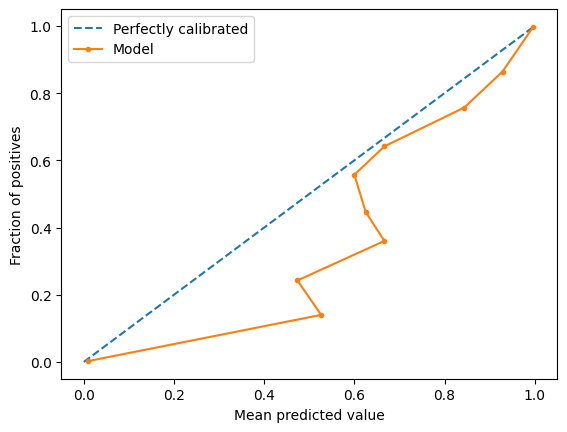

DATA:  A  MODEL:  B
0.2080881482970968


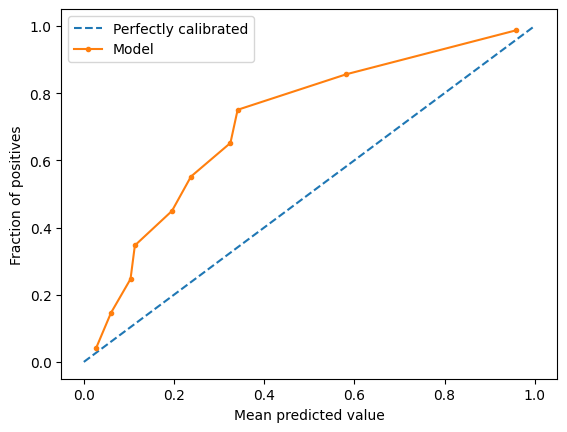

DATA:  A  MODEL:  C
0.2536945182622633


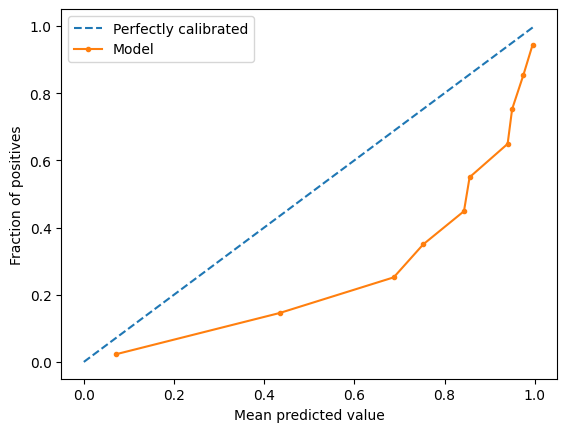

DATA:  A  MODEL:  ABC
0.10280025884440885


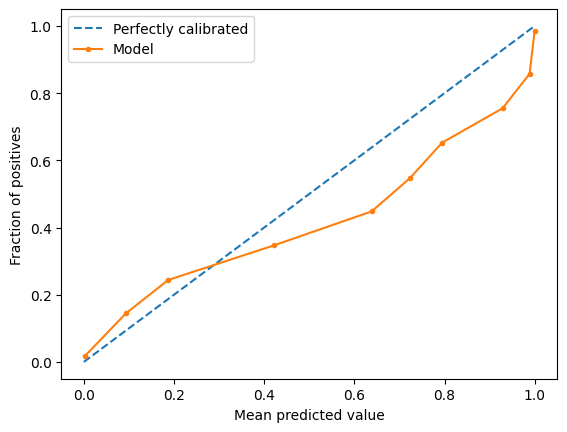

DATA:  A  MODEL:  FNC
0.12422966794549024


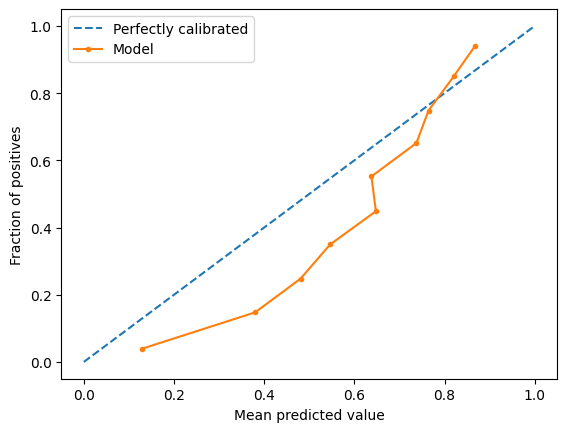

DATA:  A  MODEL:  FIN
0.07783113705210747


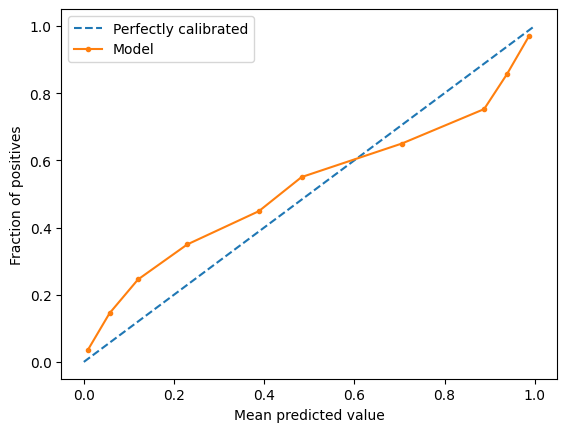

2374
DATA:  B  MODEL:  A
0.18494774434717662


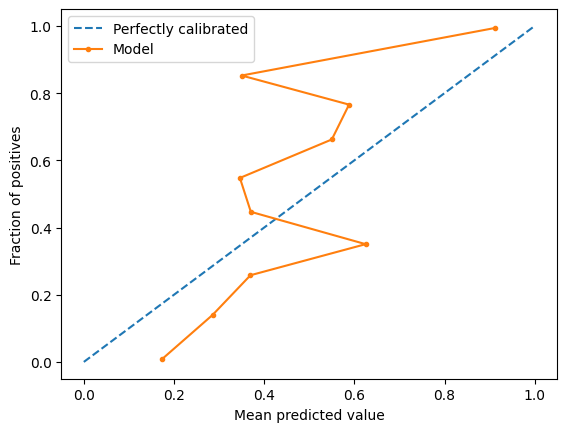

DATA:  B  MODEL:  B
0.051511792445431366


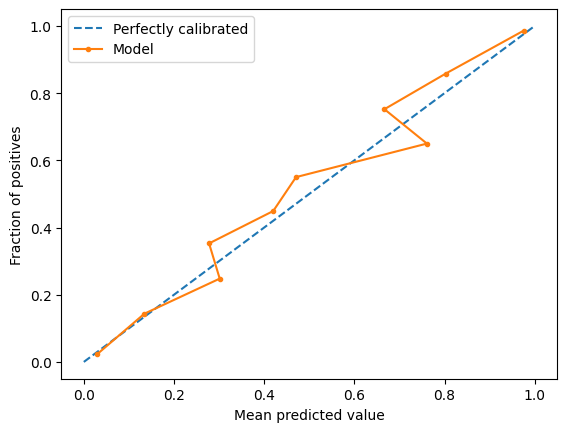

DATA:  B  MODEL:  C
0.1854421238910495


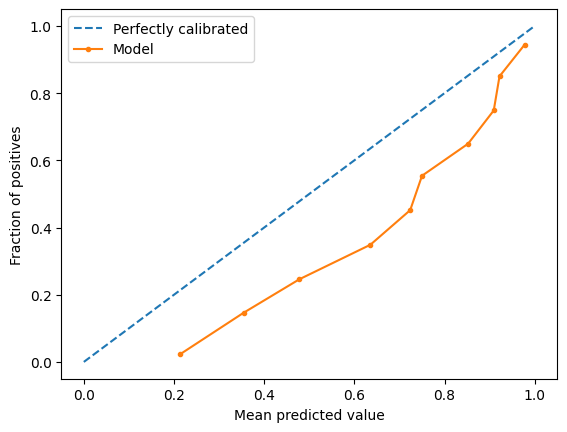

DATA:  B  MODEL:  ABC
0.116925108631308


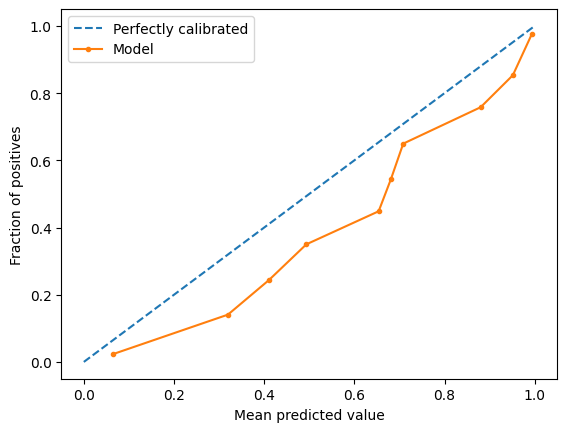

DATA:  B  MODEL:  FNC
0.10101299361229027


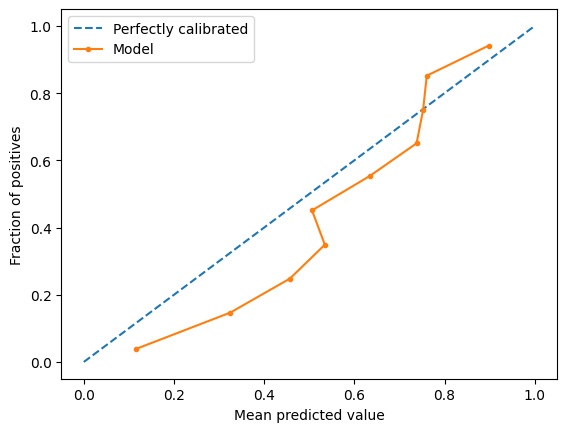

DATA:  B  MODEL:  FIN
0.020257224029339296


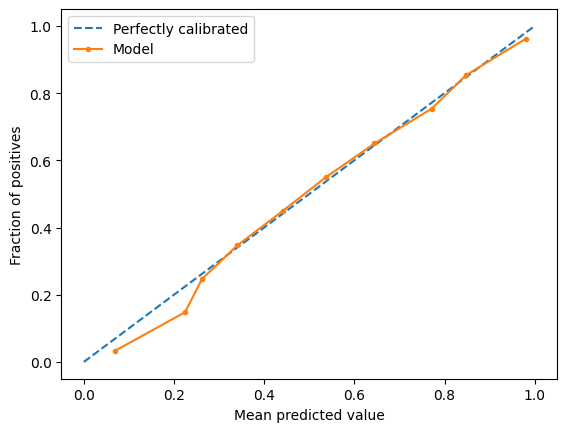

7678
DATA:  C  MODEL:  A
0.26969079926613343


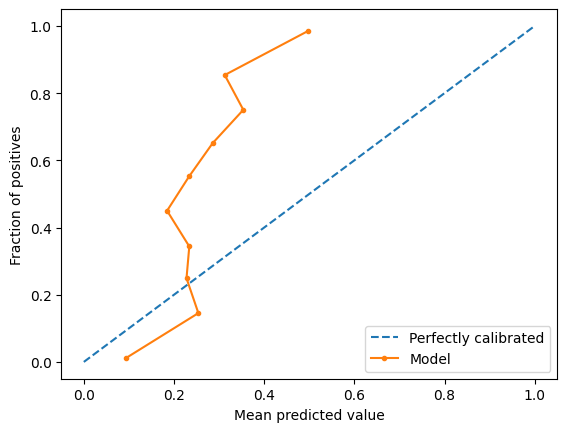

DATA:  C  MODEL:  B
0.3247942833132253


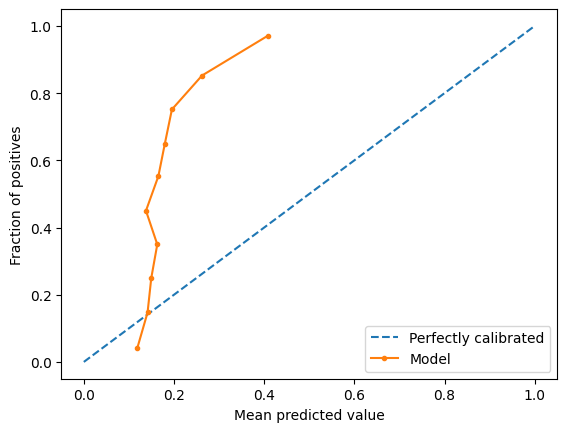

DATA:  C  MODEL:  C
0.044422557303395206


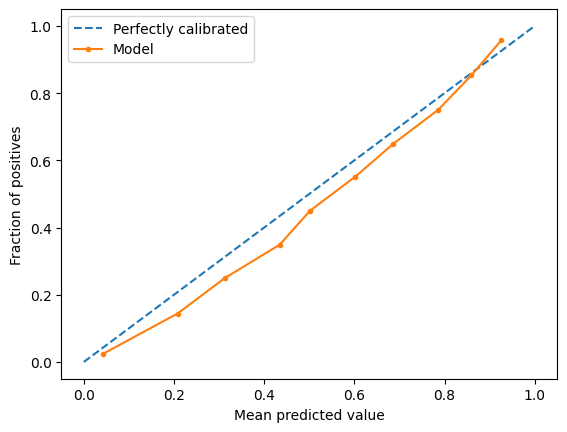

DATA:  C  MODEL:  ABC
0.07399100799013598


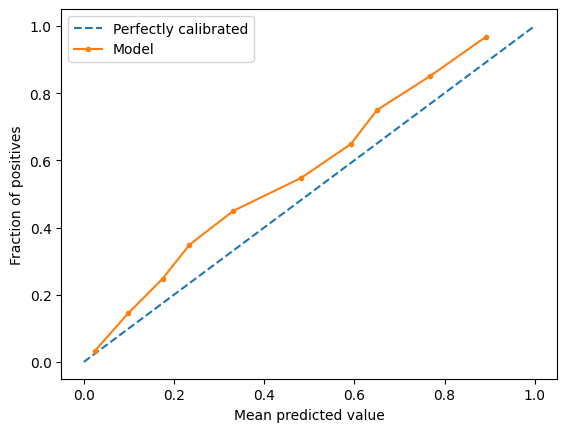

DATA:  C  MODEL:  FNC
0.2951924545187555


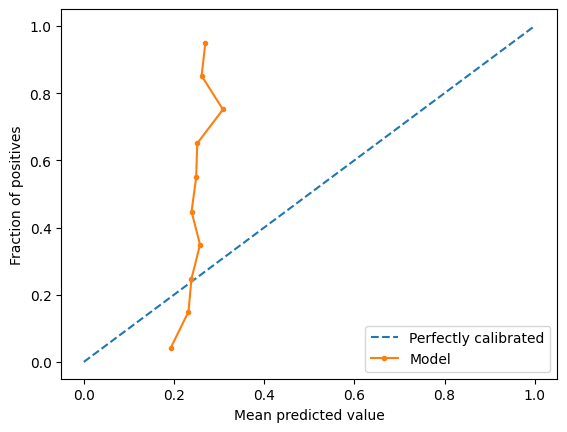

DATA:  C  MODEL:  FIN
0.2133842738118331


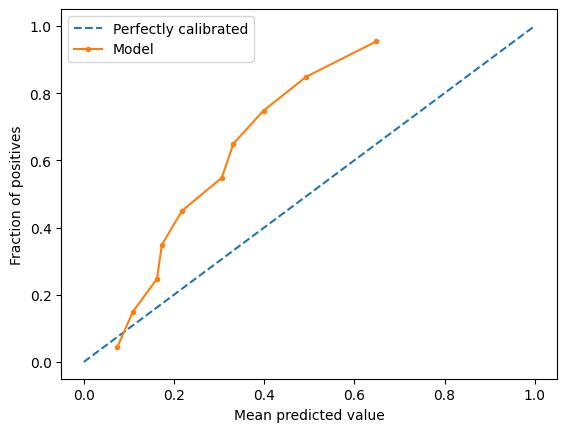

16456
DATA:  ABC  MODEL:  A
0.19279044982222104


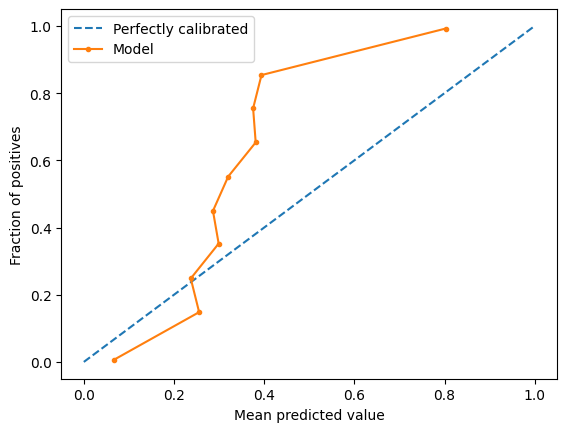

DATA:  ABC  MODEL:  B
0.2532988753624995


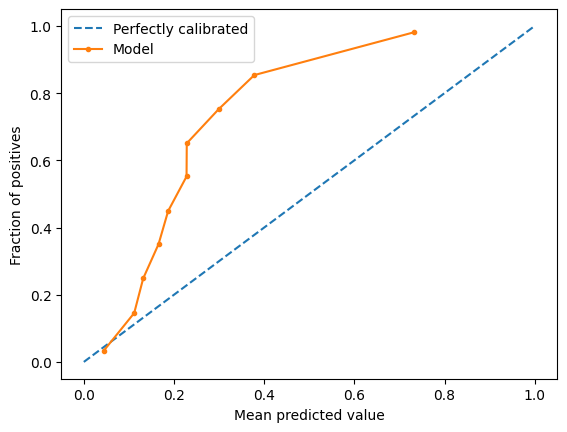

DATA:  ABC  MODEL:  C
0.15803381601692432


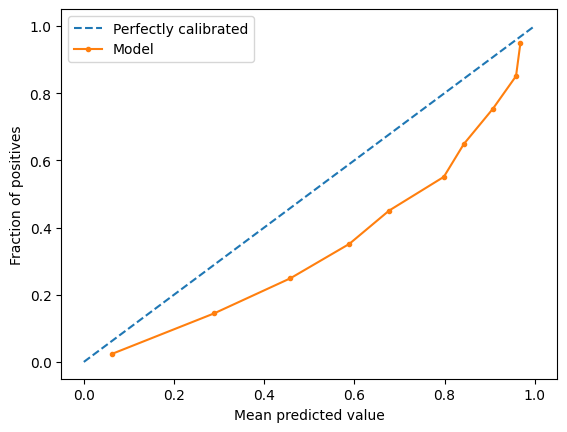

DATA:  ABC  MODEL:  ABC
0.028915483093475105


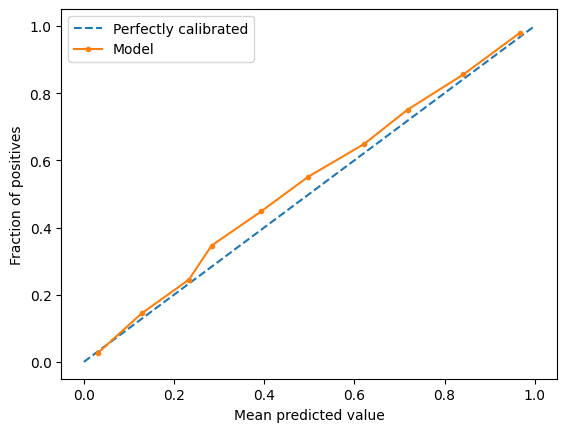

DATA:  ABC  MODEL:  FNC
0.17350993597678627


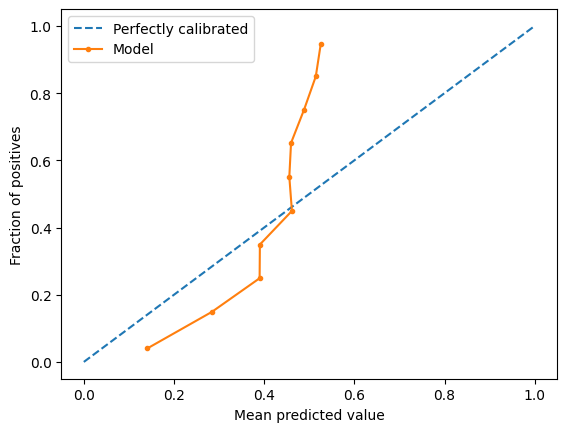

DATA:  ABC  MODEL:  FIN
0.11868056320228425


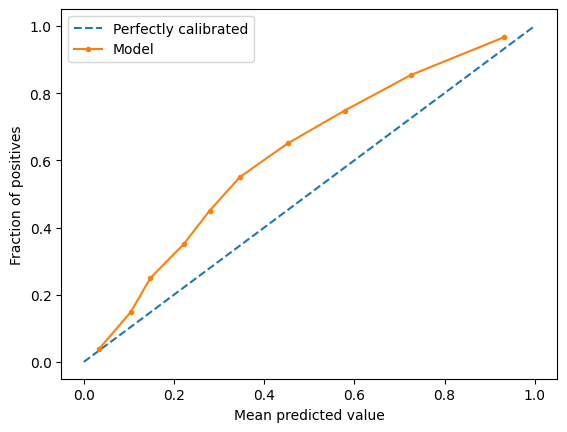

59999
DATA:  FNC  MODEL:  A
0.24948695094768122


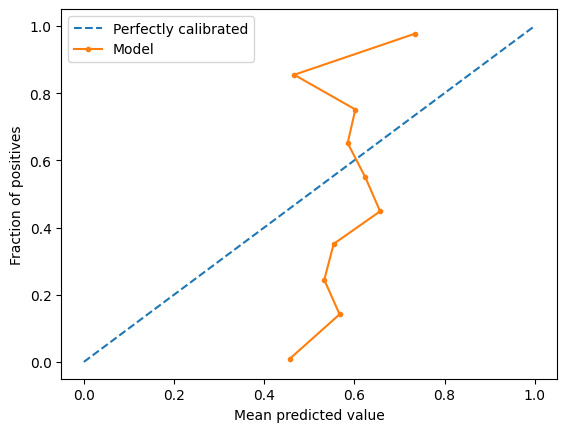

DATA:  FNC  MODEL:  B
0.2189498949538349


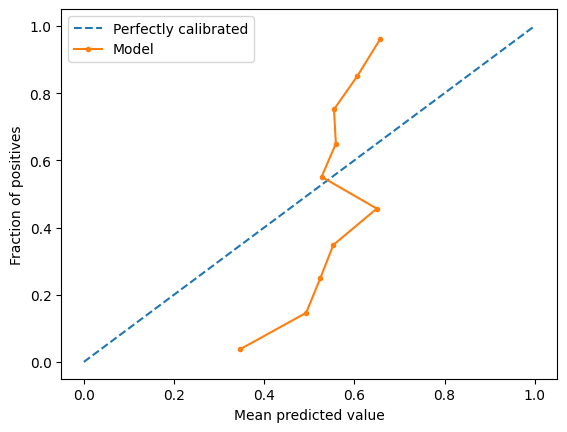

DATA:  FNC  MODEL:  C
0.2932667991927417


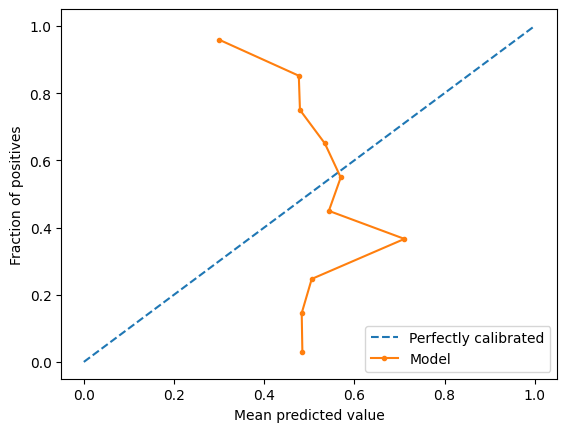

DATA:  FNC  MODEL:  ABC
0.279186246218963


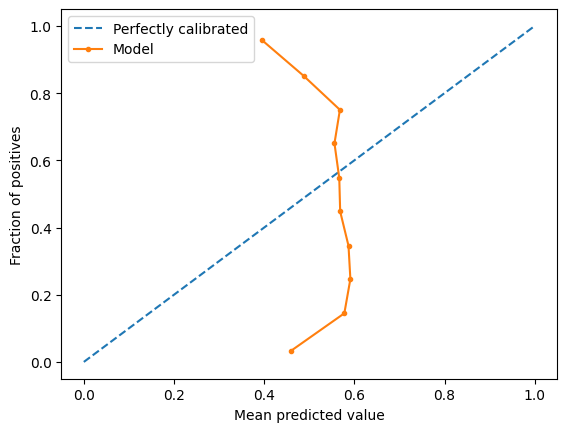

DATA:  FNC  MODEL:  FNC
0.02488086914143982


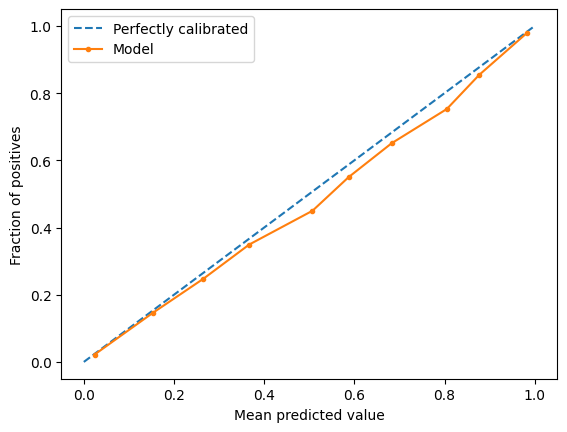

DATA:  FNC  MODEL:  FIN
0.02115376212461404


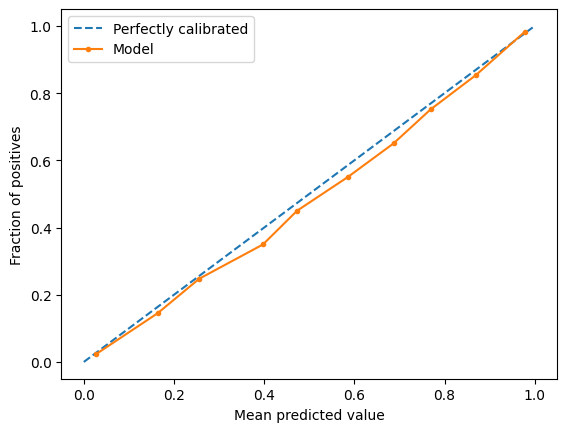

76458
DATA:  FIN  MODEL:  A
0.2305654864456943


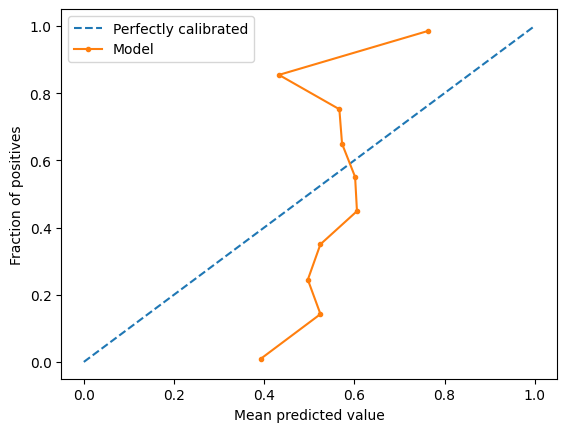

DATA:  FIN  MODEL:  B
0.20639260792360306


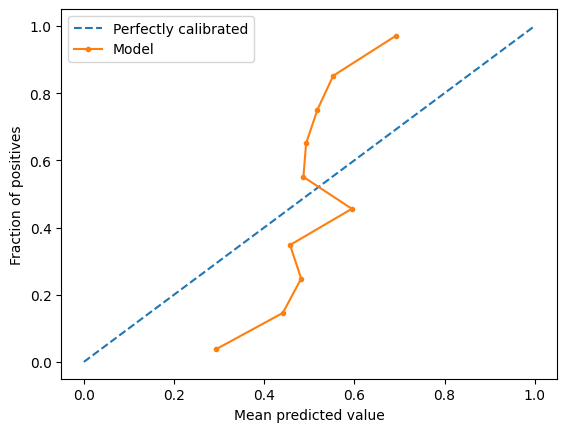

DATA:  FIN  MODEL:  C
0.2359671507302322


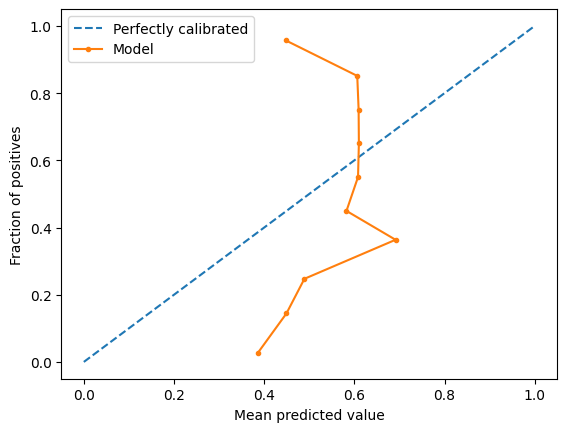

DATA:  FIN  MODEL:  ABC
0.20551549273577732


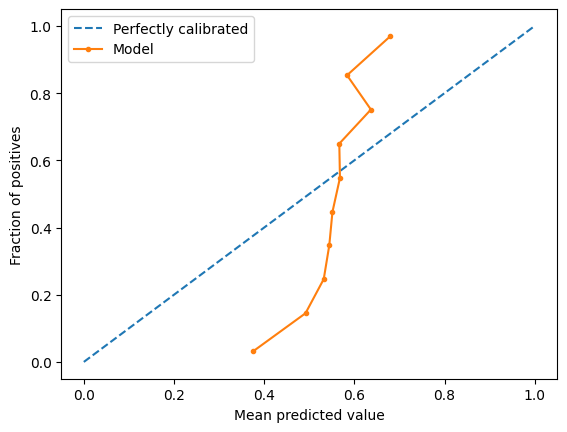

DATA:  FIN  MODEL:  FNC
0.03958735012897112


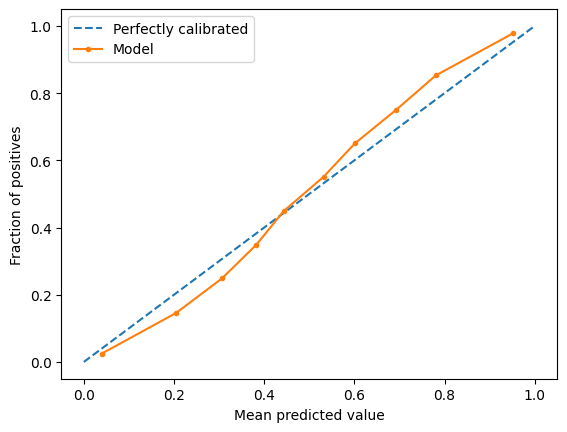

DATA:  FIN  MODEL:  FIN
0.02360096617212249


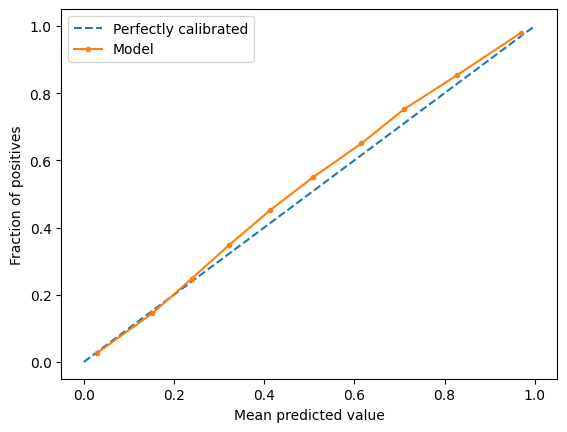

In [ ]:
# to get calibaration curve
import sklearn.calibration
import numpy as np
import matplotlib.pyplot as plt

names = ["A", "B", "C", "ABC", "FNC", "FIN"]

for data_name in names:
  test2df = pd.read_csv(root + '/ebd/testebd' + data_name + '.tsv', delimiter='\t')
  from torch import tensor
  def converter(x):
      return eval(x)
      
  test2df['embedding'] = test2df['embedding'].apply(converter)

  testset = TensorDataset(torch.stack(list(test2df['embedding'])), torch.LongTensor(list(test2df['label'])))
  testloader = DataLoader(testset)
  print(len(testloader))

  for model_name in names:
    print("DATA: ", data_name, " MODEL: ", model_name)

    model.load_state_dict(torch.load(root + "/model/model" + model_name))
    model.eval()

    test_outputs = model(torch.stack(list(test2df['embedding'])))
    test_outputs = torch.softmax(test_outputs, dim =2)
    test_outputs = test_outputs[:,:,1].cpu()

    predictions = test_outputs.detach().numpy().flatten()

    # Calculate the calibration curve

    bins = np.linspace(0, 1, num=10)
    mean_predicted_value, fraction_of_positives = sklearn.calibration.calibration_curve(((test2df['label'])), predictions, n_bins=10)
    ece = 0
    for i in range(len(mean_predicted_value)):
        ece += np.abs(mean_predicted_value[i] - fraction_of_positives[i])/10
    print(ece)



    # Plot the calibration curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    ax.plot(mean_predicted_value, fraction_of_positives, marker='.', label='Model')
    ax.set_xlabel('Mean predicted value')
    ax.set_ylabel('Fraction of positives')
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    plt.show()


